In [ ]:
import numpy as np
import os
import tensorflow as tf; tf.compat.v1.disable_eager_execution()  #importAnt for executing VAE
from tensorflow.keras.layers import Input,Dense,Flatten,Lambda,Reshape,Conv2D,Conv2DTranspose,LeakyReLU,Activation
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
np.random.seed(25)  
tf.executing_eagerly()
# from 

In [ ]:
# importing dataset and Preprocessing for feeding in
(X_train,y_train),(X_test,y_test)=mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


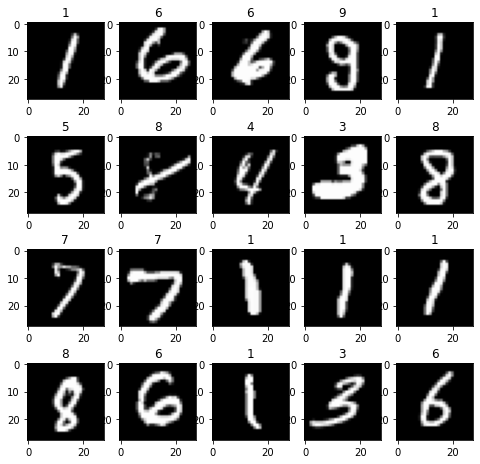

In [ ]:
fig = plt.figure(figsize=(8, 8))
# ax.ravel()
for x in range(1,21):
  index=np.random.randint(60000)
  fig.add_subplot(4, 5, x)
  plt.imshow(X_train[index],cmap='gray')
  
  plt.title(y_train[index])
plt.show()

In [ ]:
X_train.shape,X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
#as the shape is 28 by 28 for each image and there is no colour channel so in 
#order to apply convolution operation we need to add one colour channel
X_train = X_train/255
X_test = X_test/255

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

In [ ]:
X_train.shape,X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))


Important Points:
-------------------------



*   There is no correlation between output dimensions of Encoder thus independent dimensions can be used  independently to create completely new face or digit.
*   In VAE output is assumed to be continuous with Multi-Variate Normal Distribution in Latent Space.
*Output is mapped to Mean Vector and CoVariance Vector.
* Being Continuous Distribution Decoder Must Ensure that all poiints in the same Neighbourhood Produce Very similar Images when Decoded.
*Above Property Helps to chose point in latent space which it has never seen before and construct very well meaning image.


Image is encoded into Latent Space at point z using below Formula:
# x = mu + sigma * epsilon

where,
  # sigma = exp(log_var / 2 )




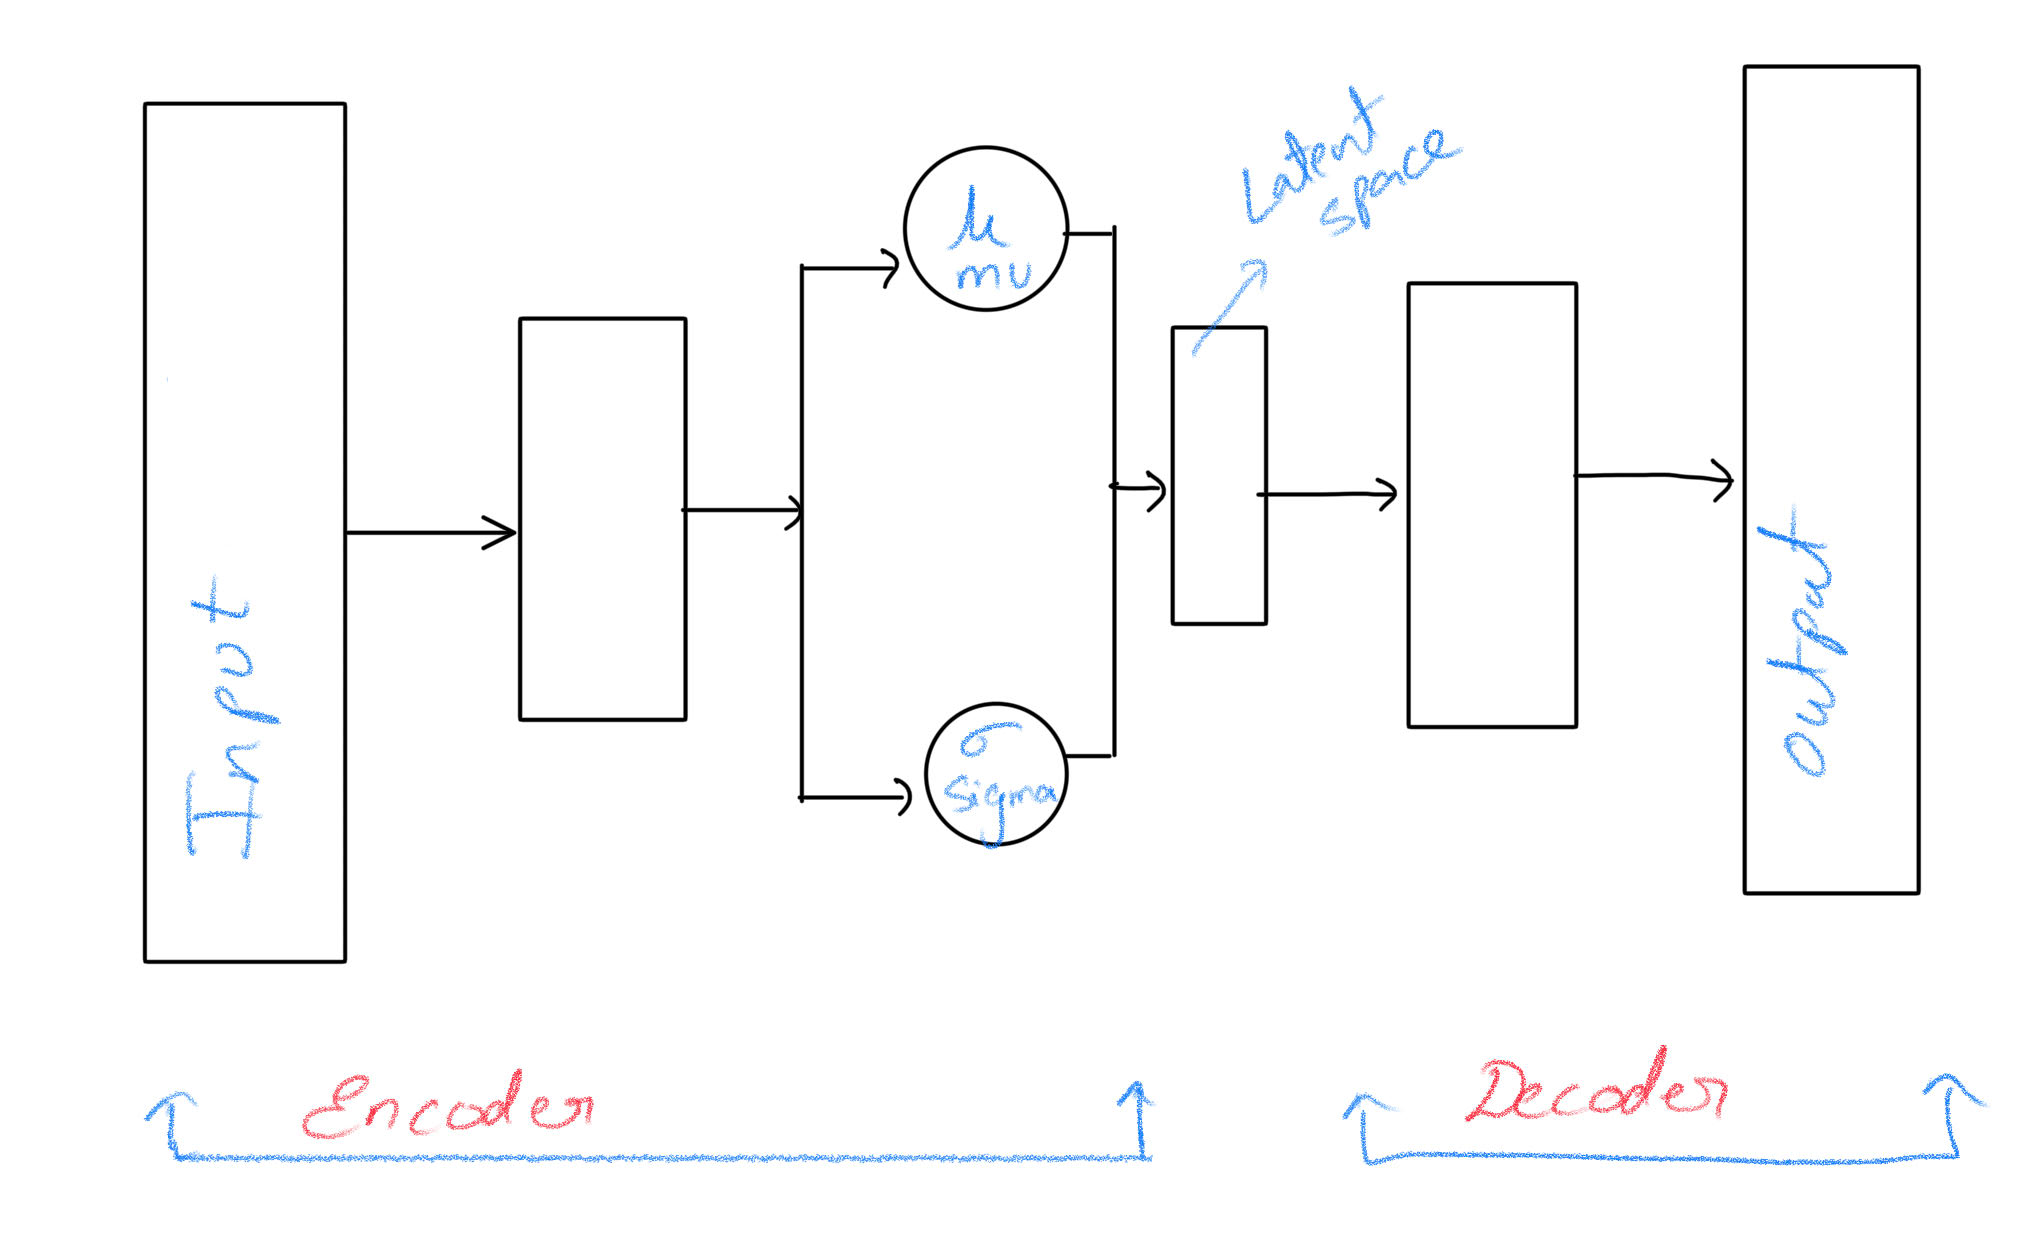

In [ ]:

#CONSTRucting encoder
image_width = X_train.shape[1]
image_height = X_train.shape[2]
channels = X_train.shape[3]
latent_space_dim = 2 # dimension of the latent space

encoder_input = Input(shape=(image_height,image_width,channels),name='Enoder_Input')
x = Conv2D(filters=32,kernel_size=3,strides=1,padding='same',
                      name='EncoderConv1')(encoder_input)
x = LeakyReLU(name='LeakyReLU_1')(x)
x = Conv2D(filters=64,kernel_size=3,strides=2,padding='same',
                      name='EncoderConv2')(x)
x = LeakyReLU(name='LeakyReLU_2')(x)
x = Conv2D(filters=64,kernel_size=3,strides=2,padding='same',
                      name='EncoderConv3')(x)
x = LeakyReLU(name='LeakyReLU_3')(x)
x = Conv2D(filters=64,kernel_size=3,strides=1,padding='same',
                      name='EncoderConv4')(x)
x = LeakyReLU(name='LeakyReLU_4')(x)

# Storing Shape before flattening as it will be usefull in case of encoder to 
# convert latent space input back to this dimension to perform further operations
# of decoding
shape_before_flattening = K.int_shape(x)[1:] 
x = Flatten()(x)

######
###### Instead Of directly Connecting it to output of latent space, Connecting 
## it to mu and sigma layer to perform certain operation

## LATENT SPACE DIMENSION IS USED HERE
mu = Dense(latent_space_dim)(x)
sigma = Dense(latent_space_dim)(x)


#Model that takes input image and gives relevant mu and sigma values
encoder_mu_log_sigma = Model(encoder_input,(mu,sigma)) # Not a necessary step as such

# Creating Function to be used in a model Throug LAMBDA LAYER
def sampling(args):
  mu, sigma = args
  epsilon = K.random_normal(K.shape(mu),mean = 0.,stddev=1.0)
  return mu + K.exp(sigma / 2) * epsilon

encoder_output = Lambda(sampling,name='encoder_output')([mu,sigma])

encoder = Model(encoder_input,encoder_output)

In [ ]:
encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Enoder_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 EncoderConv1 (Conv2D)          (None, 28, 28, 32)   320         ['Enoder_Input[0][0]']           
                                                                                                  
 LeakyReLU_1 (LeakyReLU)        (None, 28, 28, 32)   0           ['EncoderConv1[0][0]']           
                                                                                                  
 EncoderConv2 (Conv2D)          (None, 14, 14, 64)   18496       ['LeakyReLU_1[0][0]']            
                                                                                            

### Important Points For Decoder

In Autoencoder only RMSE is enough for loss between images and their reconstruction after passing through encoder and decoder.\
\
*But in VAE we also use one extra component: Kullback-leibler (KL) divergence *
\
To measure difference between probability distributions KL divergence is used.

**Note** 😃 Remaing Explanation on this topic is on Wiki Page.




#### Here Loss is a combination of Recostruction Loss and KL Divergence loss.
/
Here Reconstruction loss is factor by *r_loss_factor* and it is also one of the hyperparameter to tune accordingly.
* if KL dominates than recostructed image will be poor
* if KL is less and Reconstruction loss is heavy weighted than KL will not have much effect thus VAE experiences same problem as experienced by plain autoencoder.

In [ ]:
decoder_input = Input(shape=(latent_space_dim,),name='decoder_input')

x = Dense(np.prod(shape_before_flattening))(decoder_input)# np.prod() multiplies all th eelemnt to give same no. of nodes as encoder
x = Reshape(shape_before_flattening)(x)
x = Conv2DTranspose(filters=64,padding='same',kernel_size=3,strides=1
                    ,name='ConveT_Decoder1')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters=64,padding='same',strides=2,kernel_size=3
                    ,name='ConveT_Decoder2')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters=32,padding='same',strides=2,kernel_size=3
                    ,name='ConveT_Decoder3')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters=1,padding='same',strides=1,
                    kernel_size = 3,name='ConveT_decoder4')(x)
Decoder_output = Activation('sigmoid')(x)

decoder_model = Model(decoder_input,Decoder_output)


In [ ]:
shape_before_flattening

(7, 7, 64)

In [ ]:
np.prod(shape_before_flattening)

3136

In [ ]:
decoder_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 ConveT_Decoder1 (Conv2DTran  (None, 7, 7, 64)         36928     
 spose)                                                          
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 64)          0         
                                                                 
 ConveT_Decoder2 (Conv2DTran  (None, 14, 14, 64)       36928     
 spose)                                                    

## Making Full VAE 

In [ ]:
model_input = encoder_input  #taking encoder input as inpjut
model_output = decoder_model(encoder_output)  # taking output from decoder model 
                                  # which takes output from encoder output as input
model = Model(model_input,model_output)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Enoder_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 EncoderConv1 (Conv2D)          (None, 28, 28, 32)   320         ['Enoder_Input[0][0]']           
                                                                                                  
 LeakyReLU_1 (LeakyReLU)        (None, 28, 28, 32)   0           ['EncoderConv1[0][0]']           
                                                                                                  
 EncoderConv2 (Conv2D)          (None, 14, 14, 64)   18496       ['LeakyReLU_1[0][0]']            
                                                                                            

In [ ]:

def vae_r_loss(y_true, y_pred):
  r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
  return 1000 * r_loss

def vae_kl_loss(y_true, y_pred):
  kl_loss =  -0.5 * K.sum(1 + sigma - K.square(mu) - K.exp(sigma), axis = 1)
  return kl_loss

def vae_loss(y_true, y_pred):
  r_loss = vae_r_loss(y_true, y_pred)
  kl_loss = vae_kl_loss(y_true, y_pred)
  return  r_loss + kl_loss


model.compile(optimizer='adam',loss = vae_loss,  metrics = [vae_r_loss, vae_kl_loss])

In [ ]:
# def my_loss_fn(y_true, y_pred):
#     squared_difference = tf.square(y_true - y_pred)
#     return tf.reduce_mean(squared_difference, axis=-1)*0.5  # Note the `axis=-1`

# model.compile(optimizer='adam', loss=my_loss_fn)


In [ ]:

#training Model

#loss function is causing error
history = model.fit(x = X_train,y=X_train,epochs=20, batch_size=32, validation_data=(X_test,X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
59968/60000 [============================>.] - ETA: 0s - loss: 56.5441 - vae_r_loss: 53.1538 - vae_kl_loss: 3.3903

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 35s 580us/sample - loss: 56.5450 - vae_r_loss: 53.1546 - vae_kl_loss: 3.3904 - val_loss: 53.3334 - val_vae_r_loss: 49.6035 - val_vae_kl_loss: 3.7299
Epoch 2/20
60000/60000 [==============================] - 24s 399us/sample - loss: 51.0759 - vae_r_loss: 46.9266 - vae_kl_loss: 4.1492 - val_loss: 50.2269 - val_vae_r_loss: 45.7526 - val_vae_kl_loss: 4.4742
Epoch 3/20
60000/60000 [==============================] - 24s 395us/sample - loss: 49.6147 - vae_r_loss: 45.1827 - vae_kl_loss: 4.4320 - val_loss: 49.7126 - val_vae_r_loss: 45.3445 - val_vae_kl_loss: 4.3680
Epoch 4/20
60000/60000 [==============================] - 24s 403us/sample - loss: 48.7959 - vae_r_loss: 44.2256 - vae_kl_loss: 4.5703 - val_loss: 48.5203 - val_vae_r_loss: 43.7454 - val_vae_kl_loss: 4.7749
Epoch 5/20
60000/60000 [==============================] - 23s 390us/sample - loss: 48.2722 - vae_r_loss: 43.5996 - vae_kl_loss: 4.6726 - val_loss: 47.8226 - val_vae_r_loss: 43.1799 - 

In [ ]:
encoded = model.predict(X_train)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


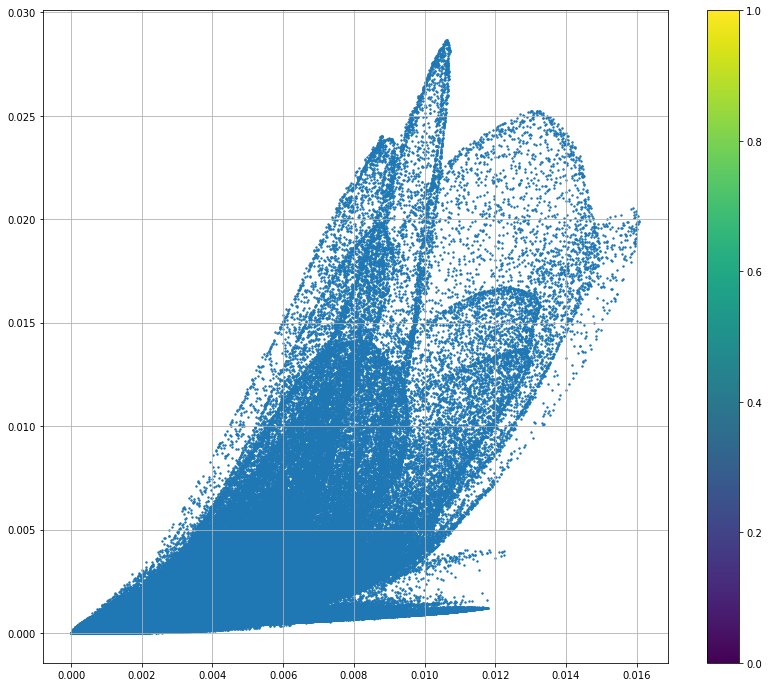

In [ ]:
plt.figure(figsize=(14,12))
plt.scatter(encoded[:,0], encoded[:,1], s=2,  cmap='hsv')
plt.colorbar()
plt.grid()
plt.show()

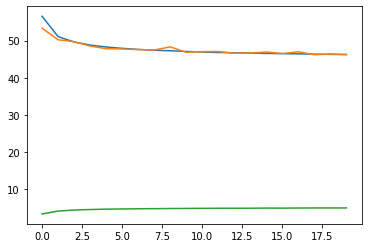

In [ ]:
# Plotting loss value decrease
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['vae_kl_loss'])
# plt.plot(history.history['accuracy'])

In [ ]:
def display_image_sequence(x_start, y_start, x_end, y_end, no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder_model.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2])
    
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                             sharey=True, figsize=(20, 7))
    counter = 0
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='gray')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


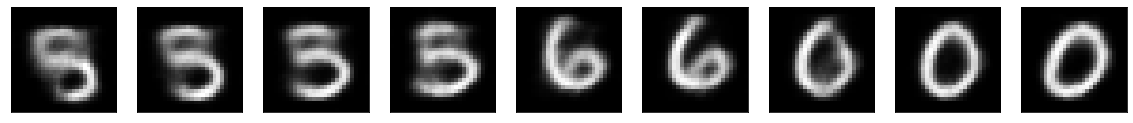

In [ ]:
# Starting point=(0,2), end point=(2,0)
display_image_sequence(0,2,2,0,9)

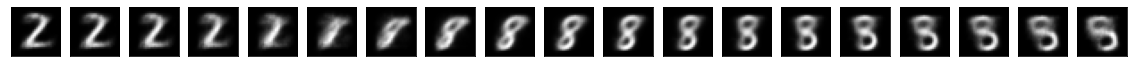

In [ ]:
# Starting point=(0,-2), end point=(0,2)
display_image_sequence(0,-2,0,2,19)